In [72]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [86]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

#### Adicionando um dataset do tensorflow


In [102]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [75]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

#### Preparando os dados

In [76]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [103]:


TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

#### Visualizando os dados


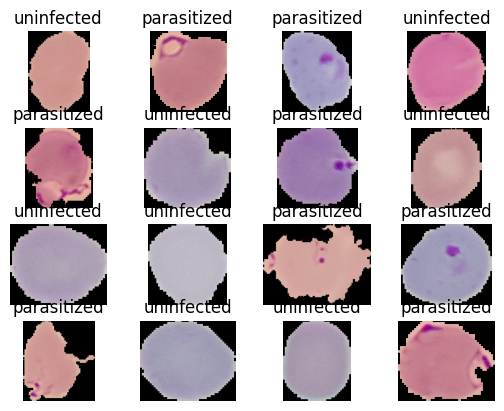

In [78]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

#### Pré Processando os dados

In [79]:
IM_SIZE = 224
def resizing_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

for image,label in train_dataset.take(1):
  print(image,label)

In [105]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True)\
                                      .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [106]:
val_dataset = val_dataset.shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True)\
                                      .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [93]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE,3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])

lenet_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [84]:
y_true = [0,1,0,0]
y_pred = [0.1, 0.91, 0, 0]

bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.049917735>

In [94]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
                      loss = BinaryCrossentropy(),
                      metrics = 'accuracy')

In [95]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 61s 84ms/step - loss: 0.5422 - accuracy: 0.7148 - val_loss: 5.4503 - val_accuracy: 0.5162
Epoch 2/20
689/689 [==============================] - 42s 61ms/step - loss: 0.2310 - accuracy: 0.9178 - val_loss: 0.4001 - val_accuracy: 0.9064
Epoch 3/20
689/689 [==============================] - 41s 60ms/step - loss: 0.1828 - accuracy: 0.9404 - val_loss: 0.1839 - val_accuracy: 0.9470
Epoch 4/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1818 - accuracy: 0.9410 - val_loss: 0.1934 - val_accuracy: 0.9365
Epoch 5/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1678 - accuracy: 0.9462 - val_loss: 0.5728 - val_accuracy: 0.5550
Epoch 6/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1524 - accuracy: 0.9515 - val_loss: 0.2037 - val_accuracy: 0.9321
Epoch 7/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1381 - accuracy: 0.9555 - val_loss: 0.3652 - val_accuracy:

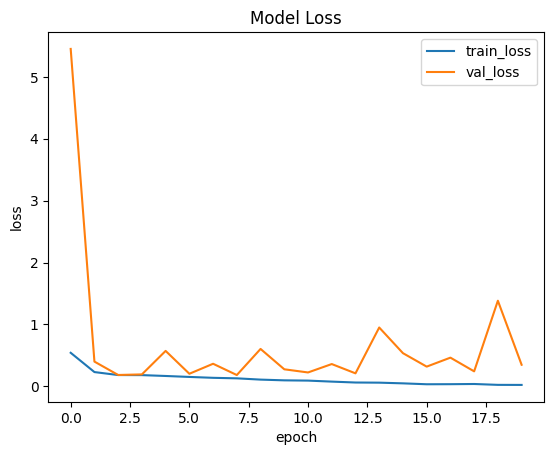

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

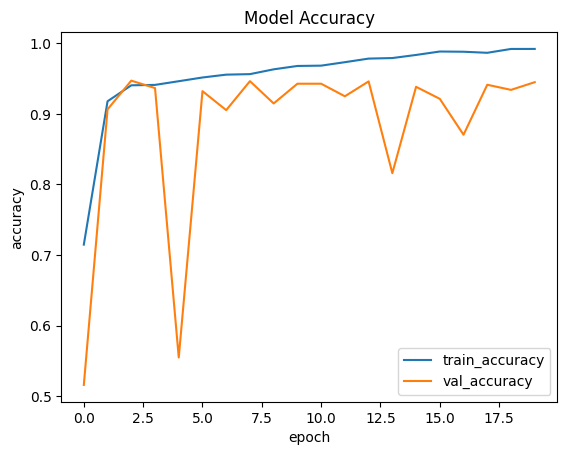

In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [107]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [108]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 0.2976 - accuracy: 0.9369


[0.29759085178375244, 0.9368879199028015]

In [112]:
def parasiteOrNot(x):
  if(x < 0.5):
    return str('N')
  else:
    return str('Y')

In [111]:
parasiteOrNot(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'U'

1/1 [==============================] - 0s 20ms/step


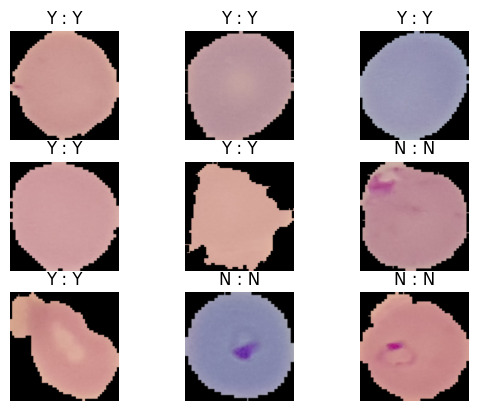

In [114]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str( parasiteOrNot(label.numpy()[0])) + " : " + str( parasiteOrNot(lenet_model.predict(image)[0][0])))
  plt.axis('off')